In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Prediction of Disease in Casava Plants

# Loading of needed Librarys and data

In [2]:
#Load Nessicery Librarys
import numpy as np 
import pandas as pd 

import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
# Any results you write to the current direct



#ory are saved as output.

from time import time

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16

from tensorflow.keras.callbacks import TensorBoard

import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import math

In [3]:
train = pd.read_csv("C:/Users/twg57/Downloads/Cassava-20210716T024150Z-001/Cassava/train.csv",dtype=str)
train_path = "C:/Users/twg57/Downloads/Cassava-20210716T024150Z-001/Cassava/train_images"
test = pd.read_csv("C:/Users/twg57/Downloads/Cassava-20210716T024150Z-001/Cassava/sample_submission.csv",dtype=str)
test_path = "C:/Users/twg57/Downloads/Cassava-20210716T024150Z-001/Cassava/test_images"
print(train.head())

         image_id label
0  1000015157.jpg     0
1  1000201771.jpg     3
2   100042118.jpg     1
3  1000723321.jpg     1
4  1000812911.jpg     3


# Exploatory analysis

# Label Exploration


In [ ]:
print('Training set summary Stats')
print('Number of image : ', len(train))
print('Number of images per catagory : ', train['label'].value_counts())

Training set summary Stats
Number of image :  21397
Number of images per catagory :  3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64


<AxesSubplot:ylabel='label'>

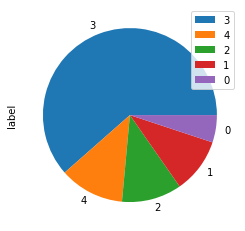

In [ ]:
df = train['label'].value_counts()
df = pd.DataFrame(df)
df.plot.pie(y='label')

Form this it appears that the data is not balanced. There are far more amount of the 3rd response or, Cassava Mosaic Disease (CMD). This could lead to some overfitting, but we will im sure when we run the model we can account for that. 

# Image analysis

error: ignored

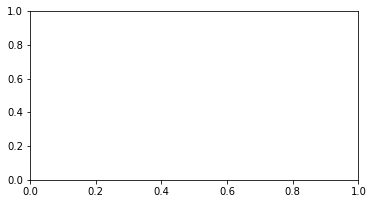

In [ ]:
def plot_imgs(img_ids, labels):
    plt.figure(figsize=(20, 18))
    
    num_samples = len(labels)
    for idx, (img_id, label) in enumerate(zip(img_ids, labels)):
        num_cols = 3
        num_rows = (num_samples // num_cols) + (num_samples % num_cols)
        plt.subplot(num_rows, num_cols, idx + 1)
        
        img = cv2.imread(train_path + '/' + img_id)
        
        # Reversing the color channle from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(img)
        plt.title(name_of_diseases[int(label)], fontsize=18)
        plt.axis('off')
        
    plt.show()
    
name_of_diseases = pd.read_json('C:/Users/twg57/Downloads/Cassava-20210716T024150Z-001/Cassava/label_num_to_disease_map.json', typ='series')   
tmp_df  = train.sample(15)
img_ids = tmp_df.image_id.values
labels  = tmp_df.label.values
plot_imgs(img_ids, labels)

The pictues are of the leaves of the plant. From looking at othes that are in the data set there are some of the stalks, as well as roots. Also the pictures range in level of closeness to the plant, as well as the lighting. 

# Image Generator 

In this section we will be creating the image generator's. These are needed to make sure that the image data can be read into the CNN model, inorder to analyze the images so that we can create the model to predict off new images. 

In [ ]:
#Determin the image size
img = plt.imread("/content/drive/MyDrive/Kaggle Projects/Cassava/train_images/"+train.iloc[0]['image_id'])
print('Images shape', img.shape)

img_test = plt.imread("/content/drive/MyDrive/Kaggle Projects/Cassava/test_images/"+test.iloc[0]['image_id'])
print('Images shape', img_test.shape)

FileNotFoundError: ignored

The images are 600 by 800 pixels. Due to the size of the images, we will need to resize them. 

Initially i resized the images to 94 by 94. THe model majorly overfit and did not learn a lot form the images. This was due to the images being so compressed that they not a lot could be gathered form the images. 

The second size that i resized the image to was 300 by 300. This did provide a much better model, but it was still not getting as good of results that i was hoping for. 

Finally I resized it to 150 by 200. This was the best image size and it wored really well for the model. 

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25,
                                  rotation_range=10, # rotation
                                  width_shift_range=0.2, # horizontal shift
                                  height_shift_range=0.2, # vertical shift
                                  zoom_range=0.2) # zoom
Val_datagen = ImageDataGenerator(rescale=1/255, validation_split=0.25)
test_datagen = ImageDataGenerator(rescale=1/255)

This indicates how the data generator will operate. For the training data initially i was not including random shifts in the data. When i did not include those the model massivly overfit. It was not learning enough of the usfull information of the pictures and more form the noise in the pictures. Once in included the changes to the images which were rotations, height and weidth changes and zooms into the images the model started to prefrome much better.

In [5]:
bs = 256

train_generator = train_datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_path,
    x_col = "image_id",
    y_col = "label",
    subset = "training",
    batch_size = bs,
    #seed = 1,
    shuffle = True,
    class_mode = "categorical",
    target_size = (150,200))

valid_generator = Val_datagen.flow_from_dataframe(
    dataframe = train,
    directory = train_path,
    x_col = "image_id",
    y_col = "label",
    subset = "validation",
    batch_size = bs,
    #seed = 1,
    shuffle = True,
    class_mode = "categorical",
    target_size = (150,200))

test_generator = test_datagen.flow_from_dataframe(
    dataframe = test,
    directory = test_path,
    x_col = "image_id",
    y_col = None,
    batch_size = bs,
    seed = 1,
    shuffle = False,
    class_mode = None,
    target_size = (150,200))

C:\Users\twg57\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3520 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


Found 13408 validated image filenames belonging to 5 classes.
Found 4469 validated image filenames belonging to 5 classes.
Found 1 validated image filenames.


C:\Users\twg57\Anaconda3\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 3520 invalid image filename(s) in x_col="image_id". These filename(s) will be ignored.
  warnings.warn(


In [6]:
tr_size = 16048
va_size = 5349
te_size = 1
tr_steps = math.ceil(tr_size / bs)
va_steps = math.ceil(va_size / bs)
te_steps = math.ceil(te_size / bs)

This is what is calculateing the batch size for the model. These are essentiually the amout of images that will be loaded in at a time, so that there are only a few images in there as opposed to all of the images. 

# CNN Model

In [ ]:
np.random.seed(1)

ConVo_model = Sequential()
ConVo_model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'same', activation = 'relu', input_shape = (150,200, 3)))
ConVo_model.add(Conv2D(filters = 64, kernel_size = (5,5), padding = 'same', activation = 'relu'))
ConVo_model.add(MaxPooling2D(pool_size = (2,2)))
ConVo_model.add(BatchNormalization())
ConVo_model.add(Dropout(0.25))
ConVo_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
ConVo_model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'same', activation = 'relu'))
ConVo_model.add(MaxPooling2D(pool_size = (2,2)))
ConVo_model.add(BatchNormalization())
ConVo_model.add(Dropout(0.5))
ConVo_model.add(Conv2D(filters = 128, kernel_size = (2,2), padding = 'same', activation = 'relu'))
ConVo_model.add(Conv2D(filters = 128, kernel_size = (2,2), padding = 'same', activation = 'relu'))
ConVo_model.add(MaxPooling2D(pool_size = (2,2)))
ConVo_model.add(BatchNormalization())
ConVo_model.add(Dropout(0.5))
ConVo_model.add(Flatten())
ConVo_model.add(Dense(128, activation='relu'))
ConVo_model.add(Dropout(0.75))
ConVo_model.add(BatchNormalization())
ConVo_model.add(Dense(5, activation='softmax'))

ConVo_model.summary()


This is the last model that was created for this project. lets talk about a few of the ones that lead us to this one.

The first model was really just a proof of concecept, to make sure that the code that i had written worked. It overfit really badly. the training set resulted in 90% accuracy, and the training was at around 60%.

The next few models that were created were larger amounts of epochs that were run. the images in these were also larger, as the first model had images that were 94 by 94 pixels. these were 300 x 300. in this case the model wasnt overfitting as bad but the model wasnt learning anything. IT was sitting at around 60%'s to the low 70%'s for accuracy. This may also of been due to the large amount of layes that were in the model. at one point there were aroiund 12 convolutionil layers, which were causing the model to overfit more and not learn to much off the noise in the images.

To combat that i took out some of the convolution layers, and added the image alterations to the training images. These really helped to make sure that the model was learinig more and not overfitting. From there i started makeing small changes till i got to the model that i have. This model starts off in the first official layers, haveing 64 filters that are 5x5. after the first initial set of convolution layers, the next couple sets have 128 filters, which went down in size to 3x3 and then 2x2. Also i made sure that there were dropout layers, between each set of convolution layers, and increasing the dropout percentage the deeper the model goes, to help reduce the amount of overfitting. 

In [ ]:
%%time 

opt = keras.optimizers.Adam(0.01)
ConVo_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

h1 = ConVo_model.fit(train_generator, steps_per_epoch=tr_steps, epochs=70,
                       validation_data=valid_generator, validation_steps=va_steps)

You will want a GPU when you run this section

The model was originally run for 10 epochs, then 20, and finally i realized that 70 epochs provided the best preformance. This model scored around 79% on Kaggle. 

In [ ]:
#Plots the training and validation accuracy and loss

start = 1
ep_rng = np.arange(start,len(h1.history['accuracy']))

plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(ep_rng, h1.history['accuracy'][start:], label='Training Accuracy')
plt.plot(ep_rng, h1.history['val_accuracy'][start:], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(ep_rng, h1.history['loss'][start:], label='Training Loss')
plt.plot(ep_rng, h1.history['val_loss'][start:], label='Validation Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()

# Save model Weights
## See next file for the submission file

In [ ]:
#Save Model Weights and Configuration
ConVo_model.save('models/my_model_v06.h5')